In [21]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [22]:
df = pd.read_csv('../data/bank_reviews.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1648 non-null   object
 1   rating  1648 non-null   int64 
 2   date    1648 non-null   object
 3   bank    1648 non-null   object
 4   source  1648 non-null   object
dtypes: int64(1), object(4)
memory usage: 64.5+ KB


### Sentiment Analysis using VADER

In [24]:
analyzer = SentimentIntensityAnalyzer()

# Define function to classify sentiment
def get_sentiment_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply VADER
df["compound_score"] = df["review"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])
df["vader_sentiment"] = df["compound_score"].apply(get_sentiment_label)

df[["review", "compound_score", "vader_sentiment"]]


,review,compound_score,vader_sentiment
0,the app is proactive and a good connections.,0.6908,positive
1,I cannot send to cbebirr app. through this app.,0.0000,neutral
2,good,0.4404,positive
3,not functional,0.0000,neutral
4,everytime you uninstall the app you have to re...,0.1739,positive
...,...,...,...
1643,Best,0.6369,positive
1644,"Waw Great and innovated,user friendly, always ...",0.8074,positive
1645,It's Best waww 🙏,0.6369,positive
1646,Always one step ahead,0.0000,neutral


In [25]:
# Mean compound score by bank and rating
summary = df.groupby(["bank", "rating"])["compound_score"].mean().reset_index()

# Count of sentiment labels per bank
sentiment_count = df.groupby(["bank", "vader_sentiment"]).size().reset_index(name="count")

summary, sentiment_count


(                           bank  rating  compound_score
 0             Bank of Abyssinia       1       -0.174007
 1             Bank of Abyssinia       2       -0.018022
 2             Bank of Abyssinia       3        0.195535
 3             Bank of Abyssinia       4        0.287791
 4             Bank of Abyssinia       5        0.340090
 5   Commercial Bank of Ethiopia       1       -0.033566
 6   Commercial Bank of Ethiopia       2        0.064595
 7   Commercial Bank of Ethiopia       3        0.123031
 8   Commercial Bank of Ethiopia       4        0.314567
 9   Commercial Bank of Ethiopia       5        0.420969
 10                  Dashen Bank       1       -0.043218
 11                  Dashen Bank       2       -0.085565
 12                  Dashen Bank       3        0.303873
 13                  Dashen Bank       4        0.322442
 14                  Dashen Bank       5        0.539752,
                           bank vader_sentiment  count
 0            Bank of Abyssinia 

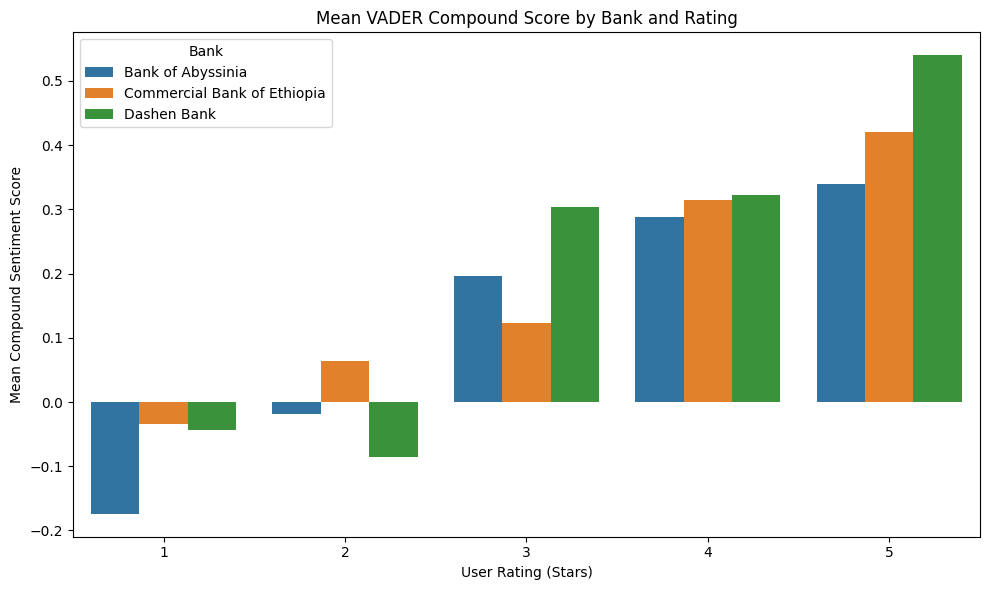

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=summary, x="rating", y="compound_score", hue="bank")

plt.title("Mean VADER Compound Score by Bank and Rating")
plt.xlabel("User Rating (Stars)")
plt.ylabel("Mean Compound Sentiment Score")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

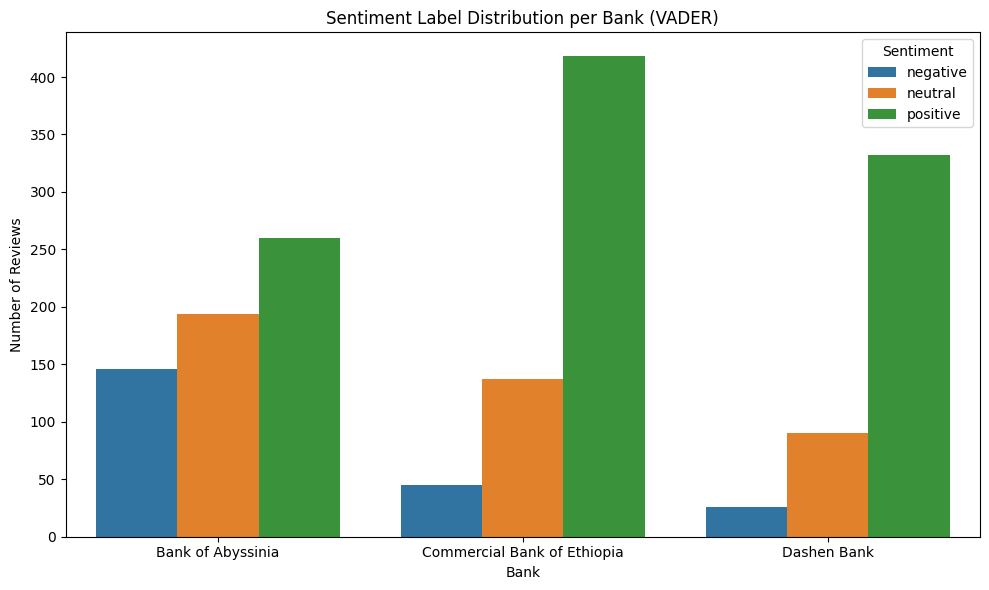

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_count, x="bank", y="count", hue="vader_sentiment")

plt.title("Sentiment Label Distribution per Bank (VADER)")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


### Sentiment Analysis using distilbert-base-uncased-finetuned-sst-2-english

In [28]:
# Load sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# Define function to apply model and classify into positive, neutral, negative
def classify_bert_sentiment(text):
    result = sentiment_pipeline(str(text))[0]
    label = result["label"].lower()  # "POSITIVE" or "NEGATIVE"
    score = result["score"]

    # Define thresholds (you can adjust these if needed)
    if score < 0.6:
        sentiment = "neutral"
    else:
        sentiment = label  # keep as "positive" or "negative"

    return pd.Series([score, sentiment])

# Apply to dataframe
df[["bert_score", "bert_sentiment"]] = df["review"].apply(classify_bert_sentiment)


Device set to use cpu


In [29]:
bert_summary = df.groupby(["bank", "rating"])["bert_score"].mean().reset_index()
bert_sentiment_count = df.groupby(["bank", "bert_sentiment"]).size().reset_index(name="count")

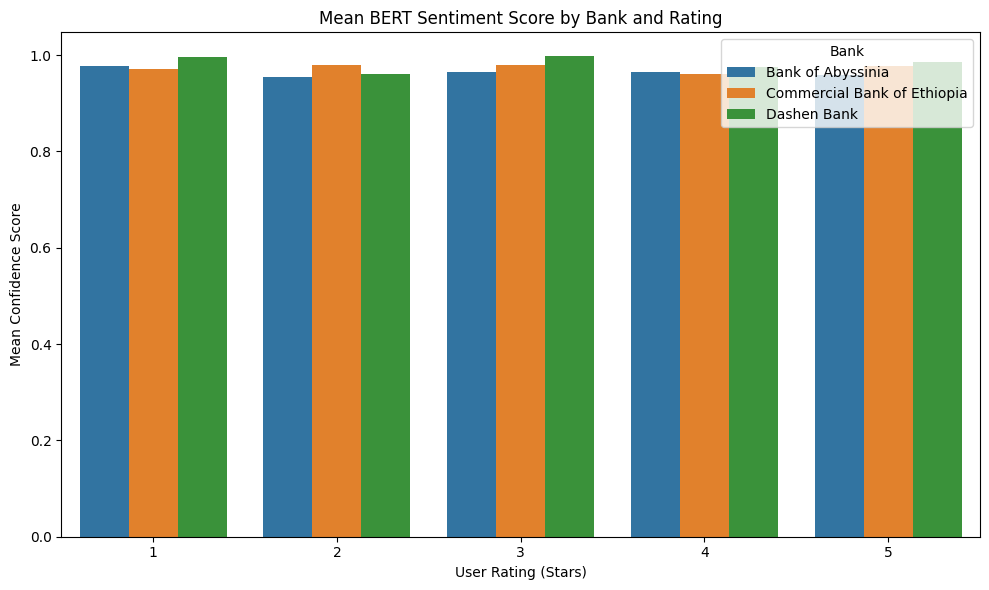

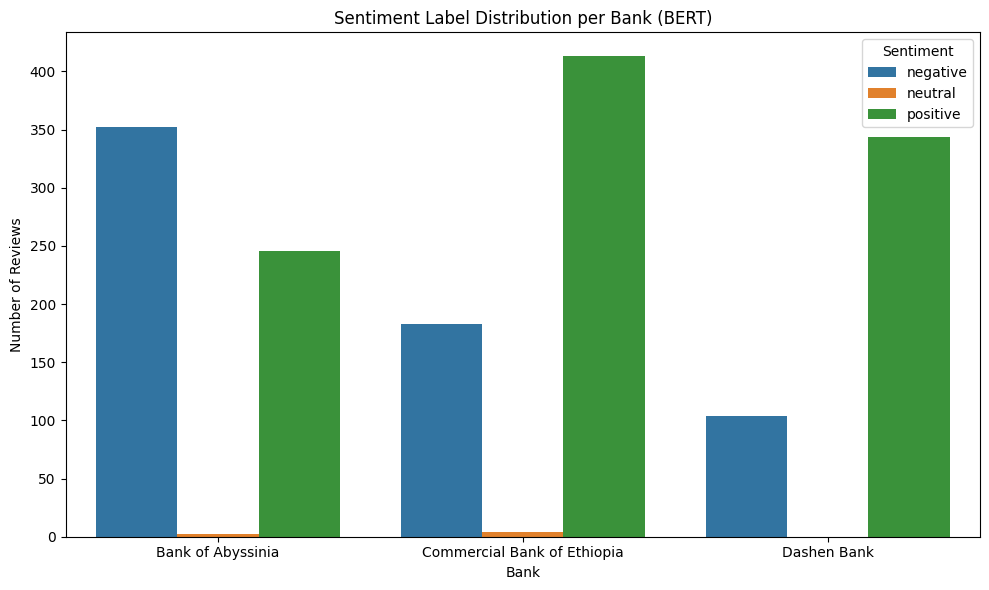

In [30]:
# Plot 1: Mean BERT score by rating and bank
plt.figure(figsize=(10, 6))
sns.barplot(data=bert_summary, x="rating", y="bert_score", hue="bank")

plt.title("Mean BERT Sentiment Score by Bank and Rating")
plt.xlabel("User Rating (Stars)")
plt.ylabel("Mean Confidence Score")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

# Plot 2: BERT Sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=bert_sentiment_count, x="bank", y="count", hue="bert_sentiment")

plt.title("Sentiment Label Distribution per Bank (BERT)")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


#### Sentiment Label Counts from Both Models

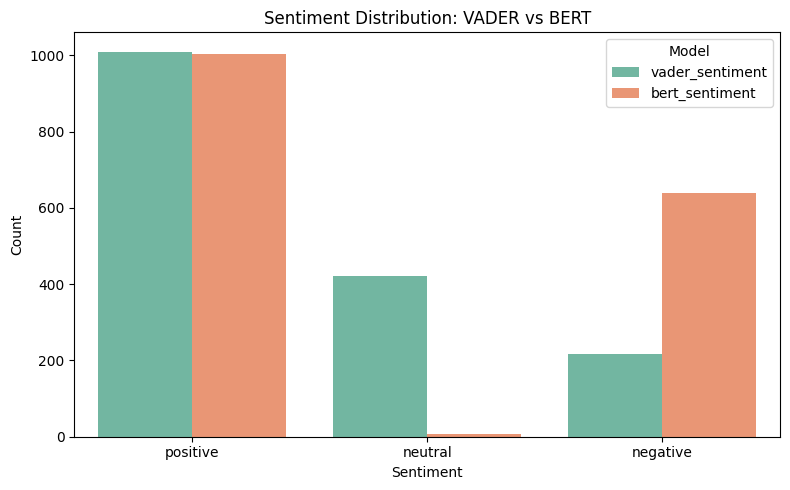

In [31]:
# Prepare data
sentiment_counts = df[['vader_sentiment', 'bert_sentiment']].melt(
    var_name='Model', value_name='Sentiment'
)

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=sentiment_counts, x='Sentiment', hue='Model', palette='Set2')
plt.title('Sentiment Distribution: VADER vs BERT')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

#### Keyword extraction

In [32]:

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 3),                  # include unigrams, bigrams, and trigrams
    max_df=0.95,                         # filter out very frequent terms
    min_df=2                             # ignore terms that appear only once
)


In [33]:
# Apply TF-IDF on all reviews
X = vectorizer.fit_transform(df["review"])
feature_names = vectorizer.get_feature_names_out()

# Total importance of each phrase across the dataset
tfidf_scores = np.asarray(X.sum(axis=0)).flatten()

# Create DataFrame of terms and scores
tfidf_df = pd.DataFrame({
    "term": feature_names,
    "score": tfidf_scores
}).sort_values(by="score", ascending=False)

# View top terms
tfidf_df.head(15)


,term,score
672,good,187.560518
72,app,110.366595
265,best,75.812081
959,nice,57.910674
215,bank,34.727420
1539,wow,31.421929
973,ok,30.205954
266,best app,29.827627
673,good app,26.782924
695,great,25.571397


In [34]:
top_terms_per_bank = {}

for bank in df['bank'].unique():
    bank_reviews = df[df['bank'] == bank]["review"]
    
    X_bank = vectorizer.fit_transform(bank_reviews)
    scores = np.asarray(X_bank.sum(axis=0)).flatten()
    terms = vectorizer.get_feature_names_out()
    
    df_bank_terms = pd.DataFrame({'term': terms, 'score': scores}).sort_values(by="score", ascending=False)
    top_terms_per_bank[bank] = df_bank_terms.head(15)


In [35]:
for bank, keywords in top_terms_per_bank.items():
    print(f"\nTop keywords for {bank}:\n")
    print(keywords.to_string(index=False))



Top keywords for Commercial Bank of Ethiopia:

      term      score
      good 101.413532
       app  49.077521
      best  32.900384
      nice  30.473785
  good app  17.007888
       cbe  15.262335
        ok  15.000000
  best app  14.492359
      like  13.146760
 excellent  12.730324
     great  12.472766
      bank  12.106178
       wow  11.318253
screenshot  10.274094
       use   9.734553

Top keywords for Bank of Abyssinia:

      term     score
      good 62.661093
       app 44.606346
      best 19.651432
       boa 16.268613
      nice 15.758672
      work 14.559431
      bank 14.395133
   working 12.075816
        ok 11.249637
     worst 10.322818
   banking 10.200294
     doesn 10.088022
    mobile  9.881418
doesn work  8.711663
     great  8.381513

Top keywords for Dashen Bank:

       term     score
        app 36.663227
       good 30.489534
       best 27.631178
     dashen 16.067597
       bank 14.540129
        wow 14.404781
       nice 13.699316
      super 13.554

##### Manual Clustering of TF-IDF Keywords
##### Grouping Logic:
- **App Performance**: Keywords describing how well the app works (e.g., "fast", "working", "crashes").
- **User Experience (UX)**: Keywords describing look, feel, and ease-of-use (e.g., "nice", "easy", "user-friendly").
- **Functionality**: Features or core operations of the app (e.g., "banking", "transfer", "application").
- **Customer Satisfaction**: Positive/negative emotional expressions (e.g., "good", "best", "excellent", "worst").
- **Issues & Complaints**: Keywords showing user pain points (e.g., "doesn work", "screenshot", "problem").

Each theme contains semantically similar keywords, helping me analyze user sentiment and feature expectations.


In [36]:
# Grouped Keywords for Commercial Bank of Ethiopia
theme_keywords = {
    "Commercial Bank of Ethiopia" : {
    "Customer Satisfaction": [
        "good", "nice", "best", "great", "excellent", "wow", "like"],
    "User Experience": [
        "easy", "use", "user friendly", "screenshot"],
    "App Performance": [
        "app", "good app", "best app", "ok", "cbe"],
    "Functionality": [
        "bank"]
},
    "Bank of Abyssinia": {
    "Customer Satisfaction": ["good", "nice", "best", "great", "worst"],
    "App Performance": [
        "app", "mobile", "ok", "doesn work", "working", "work"],
    "Functionality": ["bank", "banking", "boa"],
    "Issues & Complaints": ["doesn", "doesn work"]
},
    "Dashen Bank": {
    "Customer Satisfaction": ["good", "nice", "best", "wow", "super", "amazing"],
    "User Experience": ["easy", "application", "use"],
    "App Performance": ["app", "best app", "dashen", "dashen bank"],
    "Functionality": ["bank", "banking"]
}}


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review           1648 non-null   object 
 1   rating           1648 non-null   int64  
 2   date             1648 non-null   object 
 3   bank             1648 non-null   object 
 4   source           1648 non-null   object 
 5   compound_score   1648 non-null   float64
 6   vader_sentiment  1648 non-null   object 
 7   bert_score       1648 non-null   float64
 8   bert_sentiment   1648 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 116.0+ KB


In [38]:
def identify_themes(row, theme_keywords):
    text = row['review'].lower()
    bank = row['bank']
    themes = set()
    
    if bank in theme_keywords:
        for theme, keywords in theme_keywords[bank].items():
            for kw in keywords:
                if kw in text:
                    themes.add(theme)
    return ', '.join(themes) if themes else 'Uncategorized'

In [39]:
# Apply the theme-identifying function
df['identified_theme(s)'] = df.apply(lambda row: identify_themes(row, theme_keywords), axis=1)

# Create review_id as a new column
df['review_id'] = df.index

# Select columns to save
columns_to_save = [
    'review_id',
    'review',
    'rating',
    'date',
    'bank',
    'source',
    'vader_sentiment',       
    'compound_score', 
    'bert_sentiment',  
    'bert_score',
    'identified_theme(s)'
]

# Save to CSV
df[columns_to_save].to_csv('../bank_reviews_with_themes.csv', index=False)

print("CSV saved as 'bank_reviews_with_themes.csv'")


CSV saved as 'bank_reviews_with_themes.csv'


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review               1648 non-null   object 
 1   rating               1648 non-null   int64  
 2   date                 1648 non-null   object 
 3   bank                 1648 non-null   object 
 4   source               1648 non-null   object 
 5   compound_score       1648 non-null   float64
 6   vader_sentiment      1648 non-null   object 
 7   bert_score           1648 non-null   float64
 8   bert_sentiment       1648 non-null   object 
 9   identified_theme(s)  1648 non-null   object 
 10  review_id            1648 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 141.8+ KB
